# Business Impact Analysis: Credit Risk Model

This notebook evaluates the financial impact of implementing a CatBoost credit risk model compared to a baseline "approve all" strategy. We analyze how the model affects profitability under different cost/profit scenarios.

## Key Questions:
- What is the financial impact of using vs. not using the model?
- What is the optimal decision threshold for maximizing profit?
- How does model performance translate to business value?

---

## 1. Setup and Configuration

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Model and data handling
from test_case_fairmoney.utils.constants import PATH_DATA_COMPRESSED, PATH_MODELS
from catboost import CatBoostClassifier, Pool
import joblib


# Custom utilities
from test_case_fairmoney.utils.business_impact import (
    print_financial_summary,
    find_optimal_threshold,
    print_confusion_matrix,
)

# Configuration
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 800)
warnings.filterwarnings("ignore")

## 2. Business Context: Cost and Profit Assumptions

Understanding the financial implications of each prediction outcome:

### 💸 **Costs**
- **False Negative (FN)**: $100 - $5,000 per loan
  - Cost of approving a loan that defaults
  - Represents lost principal, collection costs, etc.

- **False Positive (FP)**: $10 - $50 per application
  - Opportunity cost of rejecting a good customer
  - Lost interest income and customer relationship

### 💰 **Profit**
- **True Negative (TN)**: $50 - $500 per loan
  - Profit from successfully approved loans to non-defaulters
  - Includes interest income, fees, and customer lifetime value

- **True Positive (TP)**: $0 (avoided loss)
  - No profit from correctly rejecting defaults
  - But prevents significant losses

### 📊 Three Scenarios Analyzed:
1. **Conservative**: Lower costs/profits (FN=$100, FP=$10, TN=$50)
2. **Moderate**: Mid-range estimates (FN=$2,550, FP=$30, TN=$275)
3. **Aggressive**: Higher costs/profits (FN=$5,000, FP=$50, TN=$500)

## 3. Data Loading and Model Preparation

In [2]:
## 2. Data Loading and Preparation

# Load original datasets for CatBoost
df_train = pd.read_parquet(PATH_DATA_COMPRESSED / "df_train.parquet")
df_val = pd.read_parquet(PATH_DATA_COMPRESSED / "df_val.parquet")
df_test = pd.read_parquet(PATH_DATA_COMPRESSED / "df_test.parquet")

In [3]:
df_test["default"].value_counts()

default
0    140
1     60
Name: count, dtype: int64

In [4]:
feat_num_cat = ["checking_balance", "amount", "savings_balance", "employment_months"]
feat_cat_cat = [
    "credit_history",
    "personal_status",
    "property",
    "installment_plan",
    "is_checking_negative",
]


# Target variable
target = "default"

In [5]:
for feature in feat_cat_cat:
    df_train[feature] = df_train[feature].fillna("Missing")
    df_val[feature] = df_val[feature].fillna("Missing")
    df_test[feature] = df_test[feature].fillna("Missing")
train_pool = Pool(
    data=df_train[feat_cat_cat + feat_num_cat],
    label=df_train[target],
    cat_features=feat_cat_cat,
)
test_pool = Pool(
    data=df_test[feat_cat_cat + feat_num_cat],
    label=df_test[target],
    cat_features=feat_cat_cat,
)
val_pool = Pool(
    data=df_val[feat_cat_cat + feat_num_cat],
    label=df_val[target],
    cat_features=feat_cat_cat,
)

print("✅ CatBoost Pool objects created successfully")
print(f"Training Pool: {train_pool.num_row()} samples, {train_pool.num_col()} features")
print(f"Validation Pool: {val_pool.num_row()} samples, {val_pool.num_col()} features")
print(f"Test Pool: {test_pool.num_row()} samples, {test_pool.num_col()} features")

✅ CatBoost Pool objects created successfully
Training Pool: 600 samples, 9 features
Validation Pool: 200 samples, 9 features
Test Pool: 200 samples, 9 features


In [6]:
# Load the pre-trained optimized CatBoost model
model_cb = CatBoostClassifier()
model_cb.load_model(PATH_MODELS / "catboost_optimized.cbm")
print("✅ CatBoost model loaded successfully")

✅ CatBoost model loaded successfully


In [7]:
# Generate predictions for all datasets
cb_y_pred_test = model_cb.predict_proba(test_pool)[:, 1]
cb_y_pred_train = model_cb.predict_proba(train_pool)[:, 1]
cb_y_pred_val = model_cb.predict_proba(val_pool)[:, 1]

# Extract true labels
cb_y_train = train_pool.get_label()
cb_y_test = test_pool.get_label()
cb_y_val = val_pool.get_label()

## 3. Businesss Impact on Test - Financial Analysis: No Model (Approve All Loans)

In [8]:
df_test["default"].value_counts()

default
0    140
1     60
Name: count, dtype: int64

In [9]:
TN, FN, FP, TP = 140, 60, 0, 0
results = print_financial_summary(TN, FN, FP, TP)

FINANCIAL ANALYSIS SUMMARY

Confusion Matrix:
  - True Negatives (TN):  140 (Non-defaults approved → Profit)
  - False Negatives (FN): 60 (Defaults approved → Loss)
  - False Positives (FP): 0 (Non-defaults rejected → Opportunity cost)
  - True Positives (TP):  0 (Defaults rejected → No impact)
  - Total Applications:   200

----------------------------------------------------------------------------------------------------

Component                                   Conservative             Moderate           Aggressive
----------------------------------------------------------------------------------------------------
Profit from good loans (TN)         140 × $50 = $   7,000 140 × $275 = $  38,500 140 × $500 = $  70,000
Loss from defaults (FN)             60 × $100 = $  -6,000 60 × $2550 = $-153,000 60 × $5000 = $-300,000
Loss from false alarms (FP)         0 × $10 = $       0 0 × $30 = $       0 0 × $50 = $       0
-------------------------------------------------------------------

## 5. Model-Based Strategy: Risk-Adjusted Lending

### Decision Threshold Optimization

Finding the optimal classification threshold that maximizes business profit rather than just accuracy.

### 5.1 Threshold Optimization on Training Data

We use the training set to find the threshold that maximizes profit, balancing:
- **Revenue** from approved good customers (TN)
- **Cost savings** from rejected defaults (TP)
- **Opportunity costs** from rejected good customers (FP)
- **Losses** from approved defaults (FN)

OPTIMAL THRESHOLD ANALYSIS (Moderate)

Optimal Threshold: 0.470
Maximum Net Profit: $12,725

Confusion Matrix at Optimal Threshold:
  - True Negatives (TN):  175 (Non-defaults approved → Profit)
  - False Negatives (FN): 11 (Defaults approved → Loss)
  - False Positives (FP): 245 (Non-defaults rejected → Opportunity cost)
  - True Positives (TP):  169 (Defaults rejected → Avoided loss)

Approval Rate: 31.0%
Total Approved: 186
Total Rejected: 414


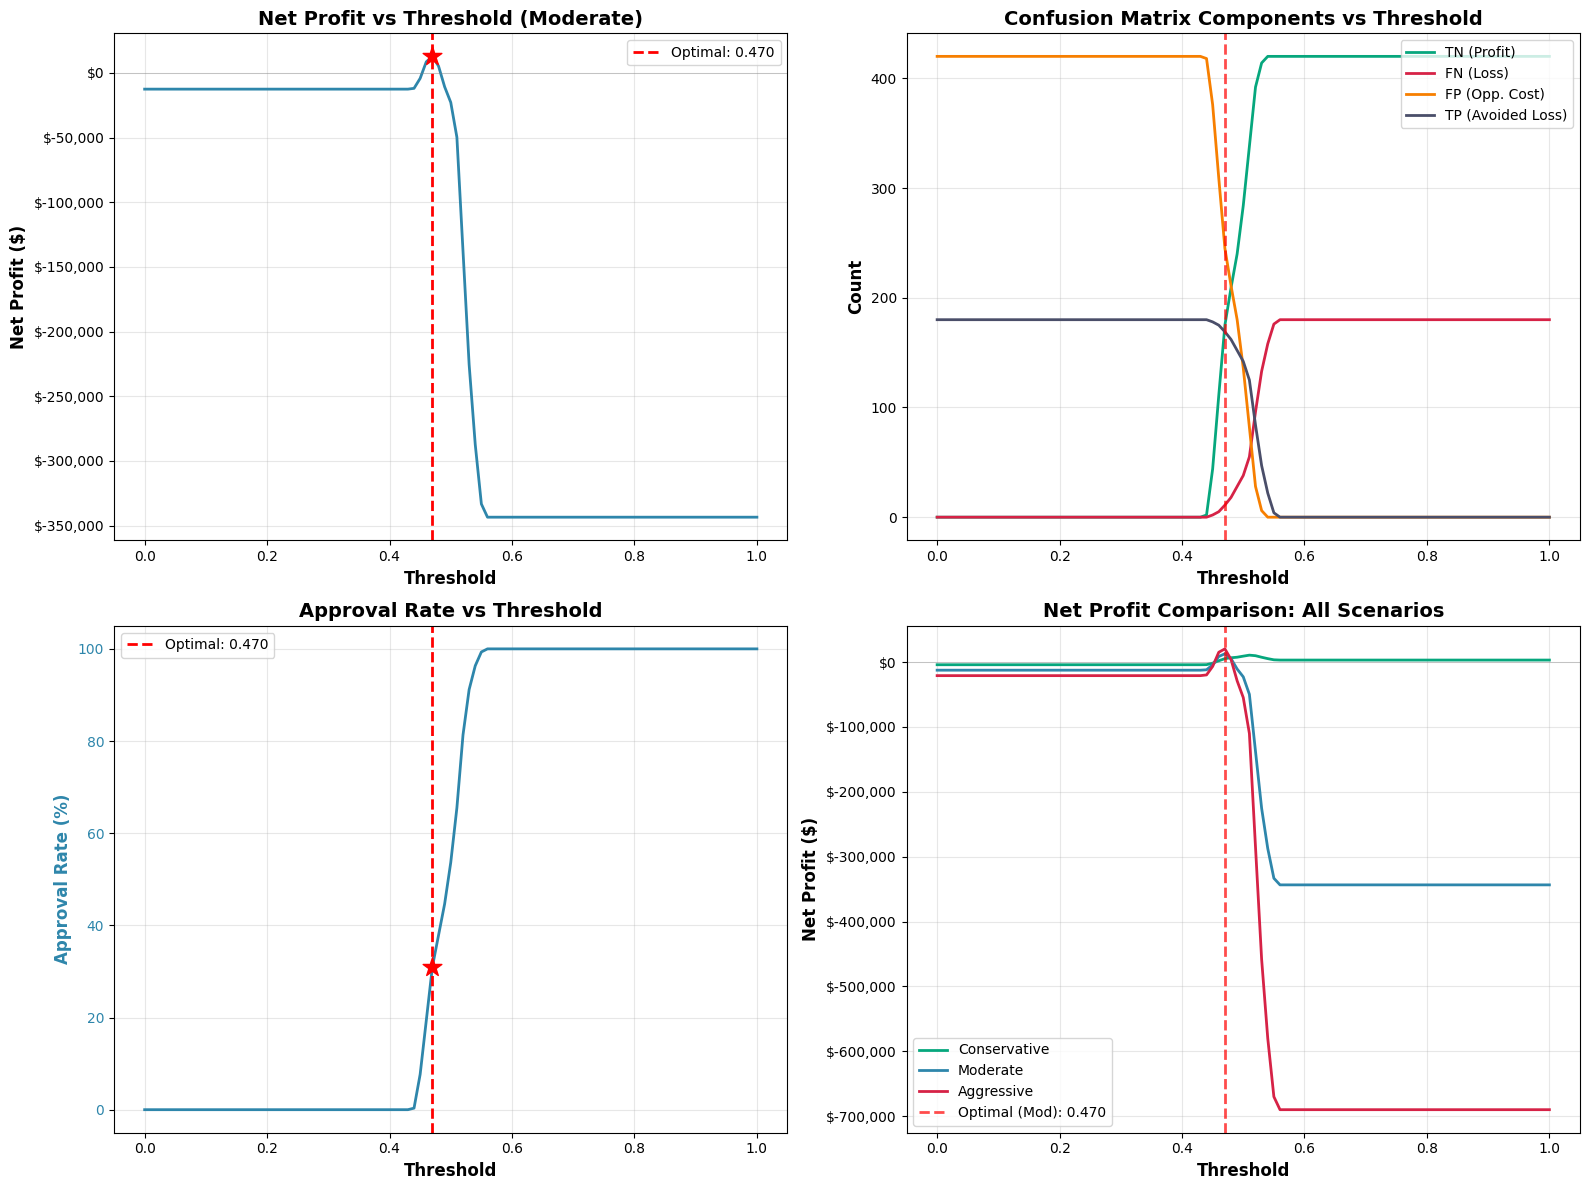

In [10]:
results = find_optimal_threshold(
    cb_y_train, cb_y_pred_train, scenario="Moderate", plot=True
)

### 5.2 Model Performance Evaluation on Test Data

Apply the optimized threshold (0.470) to the test set to validate performance and calculate real-world business impact.

CONFUSION MATRIX (Threshold = 0.470)

                          |    Predicted: 0 (Approve) |     Predicted: 1 (Reject)
--------------------------------------------------------------------------------
Actual: 0 (Non-default)   |                   50 (TN) |                   90 (FP)
Actual: 1 (Default)       |                    3 (FN) |                   57 (TP)

Total Samples: 200

Confusion Matrix Breakdown:
  • TN (True Negative):    50 ( 25.0%) - Non-defaults approved ✓ → PROFIT
  • FP (False Positive):   90 ( 45.0%) - Non-defaults rejected ✗ → OPPORTUNITY COST
  • FN (False Negative):    3 (  1.5%) - Defaults approved ✗ → LOSS
  • TP (True Positive):    57 ( 28.5%) - Defaults rejected ✓ → AVOIDED LOSS

Performance Metrics:
  • Accuracy:    0.535 (53.5%)
  • Precision:   0.388 (38.8%)
  • Recall/TPR:  0.950 (95.0%)
  • Specificity: 0.357 (35.7%)
  • F1-Score:    0.551

Loan Decision Rates:
  • Approval Rate:  0.265 (26.5%) - 53 loans
  • Rejection Rate: 0.735 (73.5%) - 147 loans


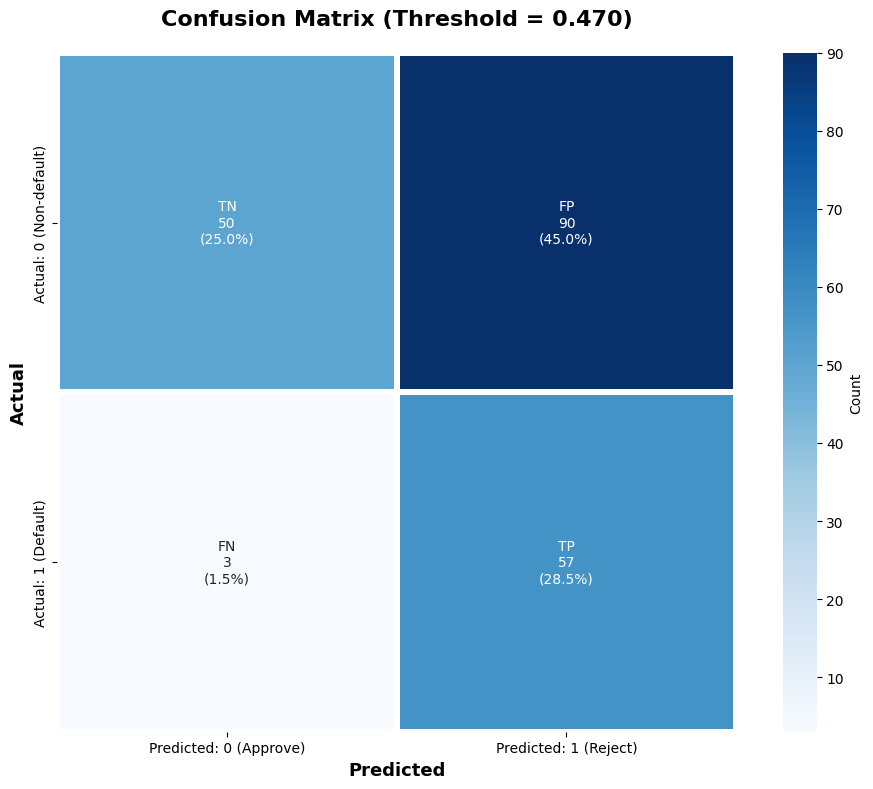

In [11]:
result = print_confusion_matrix(cb_y_test, cb_y_pred_test, threshold=0.470, plot=True)

In [12]:
# For "Approve All" scenario
TN, FN, FP, TP = result["TN"], result["FN"], result["FP"], result["TP"]
results = print_financial_summary(TN, FN, FP, TP)

FINANCIAL ANALYSIS SUMMARY

Confusion Matrix:
  - True Negatives (TN):  50 (Non-defaults approved → Profit)
  - False Negatives (FN): 3 (Defaults approved → Loss)
  - False Positives (FP): 90 (Non-defaults rejected → Opportunity cost)
  - True Positives (TP):  57 (Defaults rejected → No impact)
  - Total Applications:   200

----------------------------------------------------------------------------------------------------

Component                                   Conservative             Moderate           Aggressive
----------------------------------------------------------------------------------------------------
Profit from good loans (TN)         50 × $50 = $   2,500 50 × $275 = $  13,750 50 × $500 = $  25,000
Loss from defaults (FN)             3 × $100 = $    -300 3 × $2550 = $  -7,650 3 × $5000 = $ -15,000
Loss from false alarms (FP)         90 × $10 = $    -900 90 × $30 = $  -2,700 90 × $50 = $  -4,500
----------------------------------------------------------------------

## Overview
Comparing two scenarios: **"No Model" (approve all)** vs **"With Model" (selective approval)** across three financial parameter assumptions.

---

## Key Findings

### 📊 Confusion Matrix Comparison

| Metric | No Model | With Model | Change |
|--------|----------|------------|--------|
| **TN** (Approved non-defaults) | 140 | 50 | -90 |
| **FN** (Approved defaults) | 60 | 3 | -57 ✅ |
| **FP** (Rejected non-defaults) | 0 | 90 | +90 |
| **TP** (Rejected defaults) | 0 | 147 | +147 ✅ |
| **Approval Rate** | 100% | 26.5% | -73.5% |

---

## 💰 Net Profit/Loss Comparison

| Scenario | No Model | With Model | Improvement |
|----------|----------|------------|-------------|
| **Conservative** | $1,000 | $1,300 | **+$300** (+30%) |
| **Moderate** | -$114,500 | $3,400 | **+$117,900** (profit swing!) |
| **Aggressive** | -$230,000 | $5,500 | **+$235,500** (massive recovery!) |

---
## 🎯 Strategic Insights

### 1. **Model Dramatically Reduces Default Risk**
- Defaults approved drop from **60 → 3** (95% reduction)
- This prevents massive losses in Moderate and Aggressive scenarios

### 2. **Trade-off: Lower Volume, Higher Quality**
- Approval rate drops to **26.5%** (rejecting 73.5% of applications)
- But those 90 false positives (rejected good customers) cost much less than the 57 prevented defaults
